In [9]:
import sys
import os
import types
import warnings
import glob
import regex as re
import netCDF4 as nc
import rasterio
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import ipywidgets as widgets
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import chardet
import pyperclip
from geopandas import GeoDataFrame
from shapely.geometry import Point
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from rasterio.transform import from_origin
from rasterstats import zonal_stats
from shapely.geometry import LineString
from matplotlib.path import Path
from matplotlib.colors import Normalize
from netCDF4 import Dataset
from pyproj import CRS
from IPython.display import display
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from _windbreaks_helpers import *

In [10]:
warnings.filterwarnings('ignore')

In [11]:
%store -r src_dir
%store -r extent_coords
%store -r crop_data
%store -r ol_crop_data_clip
%store -r ol_crop_data_iqr_rm
%store -r ol_crop_data_std_rm
#%store -r crop_cvr_gdf

In [12]:
# # Uncomment and run if unable to recover previously stored src_dir
# 
# # Path to the directory
# directory = 'Data'
# 
# # Check if the directory exists
# if os.path.isdir(directory):
#     src_dir = directory
# else:
#     src_dir = None
# 
# print('The Data source directory is:', src_dir)
# 
# %store src_dir

In [13]:
# # Uncomment and run if unable to recover previously stored extent_coords

# Project extents
extent_coords = {'min_lat': 36.9314320, 'max_lat': 43.1345169, 
                 'min_lon': -104.2232889, 'max_lon': -94.5426297}
print('The project extents are: ', extent_coords)
%store extent_coords

The project extents are:  {'min_lat': 36.931432, 'max_lat': 43.1345169, 'min_lon': -104.2232889, 'max_lon': -94.5426297}
Stored 'extent_coords' (dict)


In [14]:
# # Uncomment and run if unable to recover previously stored crop_data
# crop_data = pd.read_csv(os.path.join(src_dir, 'crop_loss_COL/crop_data_filtered.csv'))
# ol_crop_data_clip = pd.read_csv(os.path.join(src_dir, 'crop_loss_COL/crop_data_clip_filtered.csv'))
# ol_crop_data_iqr_rm = pd.read_csv(os.path.join(src_dir, 'crop_loss_COL/crop_data_IQR_filtered.csv'))
# ol_crop_data_std_rm = pd.read_csv(os.path.join(src_dir, 'crop_loss_COL/crop_data_std_filtered.csv'))
# %store crop_data
# %store ol_crop_data_clip
# %store ol_crop_data_iqr_rm
# %store ol_crop_data_std_rm
# %store crop_cvr_gdf

In [6]:
crop_data.head()

,yrmo,fips,year,month,st_abb,st_code,state,co_code,co_name,crop_name,crop_code,col_des,col_code,indemnity
0,201404,20001,2014,4,KS,20,KANSAS,1,ALLEN,CORN,41,WIND/EXCESS WIND,61,4952.0
1,201407,20005,2014,7,KS,20,KANSAS,5,ATCHISON,CORN,41,WIND/EXCESS WIND,61,2290.0
2,201407,20005,2014,7,KS,20,KANSAS,5,ATCHISON,CORN,41,WIND/EXCESS WIND,61,4936.0
3,201402,20007,2014,2,KS,20,KANSAS,7,BARBER,WHEAT,11,WIND/EXCESS WIND,61,1181.0
4,201402,20007,2014,2,KS,20,KANSAS,7,BARBER,WHEAT,11,WIND/EXCESS WIND,61,14769.0


In [3]:
print_cols(crop_data)


 Dataframe columns: 

Index: 0, Column Name: yrmo, Data Type: int64
Index: 1, Column Name: fips, Data Type: int64
Index: 2, Column Name: year, Data Type: int64
Index: 3, Column Name: month, Data Type: int64
Index: 4, Column Name: st_abb, Data Type: object
Index: 5, Column Name: st_code, Data Type: int64
Index: 6, Column Name: state, Data Type: object
Index: 7, Column Name: co_code, Data Type: int64
Index: 8, Column Name: co_name, Data Type: object
Index: 9, Column Name: crop_name, Data Type: object
Index: 10, Column Name: crop_code, Data Type: int64
Index: 11, Column Name: col_des, Data Type: object
Index: 12, Column Name: col_code, Data Type: int64
Index: 13, Column Name: indemnity, Data Type: float64



In [ ]:
# crop_cvr_gdf.head()

In [ ]:
# print_cols(crop_cvr_gdf)

In [18]:
ol_crop_data_clip_df = ol_crop_data_clip.to_frame()
# Assume 'crop_data', 'ol_crop_data_iqr_rm', 'ol_crop_data_std_rm'
# are names of actual DataFrame variables

dataframe_dict = {
    'crop_data': crop_data,
    'ol_crop_data_clip': ol_crop_data_clip_df,  # Changed this line to use DataFrame instead
    'ol_crop_data_iqr_rm': ol_crop_data_iqr_rm,
    'ol_crop_data_std_rm': ol_crop_data_std_rm
}

for df_name, df in dataframe_dict.items():
    df['yrmo'] = pd.to_datetime(df['yrmo'], format='%Y%m')

KeyError: 'yrmo'

In [15]:

# Create new 'year' and 'month' columns
crop_data['year'] = crop_data['yrmo'].dt.year
crop_data['month'] = crop_data['yrmo'].dt.month

In [16]:
# Grouping by 'year' and 'fips' and getting the sum for the 'indemnity' column
crop_ind_by_yr_fps = crop_data.groupby(['year', 'fips']).indemnity.sum().reset_index()

# Write it to .csv file
crop_ind_by_yr_fps.to_csv('Output/crop_ind_by_yr_fps.csv', index=False)

# Grouping by 'yrmo' and 'fips' and getting the sum for the 'indemnity' column
crop_ind_by_yrmo_fps = crop_data.groupby(['yrmo', 'fips']).indemnity.sum().reset_index()

# Write it to .csv file
crop_ind_by_yrmo_fps.to_csv('Output/crop_ind_by_yrmo_fps.csv', index=False)

# Grouping by 'yrmo', 'fips', and 'crop_name' and getting the sum for the 'indemnity' column
crop_ind_by_yrmo_fps_crop = crop_data.groupby(['yrmo', 'fips', 'crop_name']).indemnity.sum().reset_index()

# Write it to .csv file
crop_ind_by_yrmo_fps_crop.to_csv('Output/crop_ind_by_yrmo_fps_crop.csv', index=False)

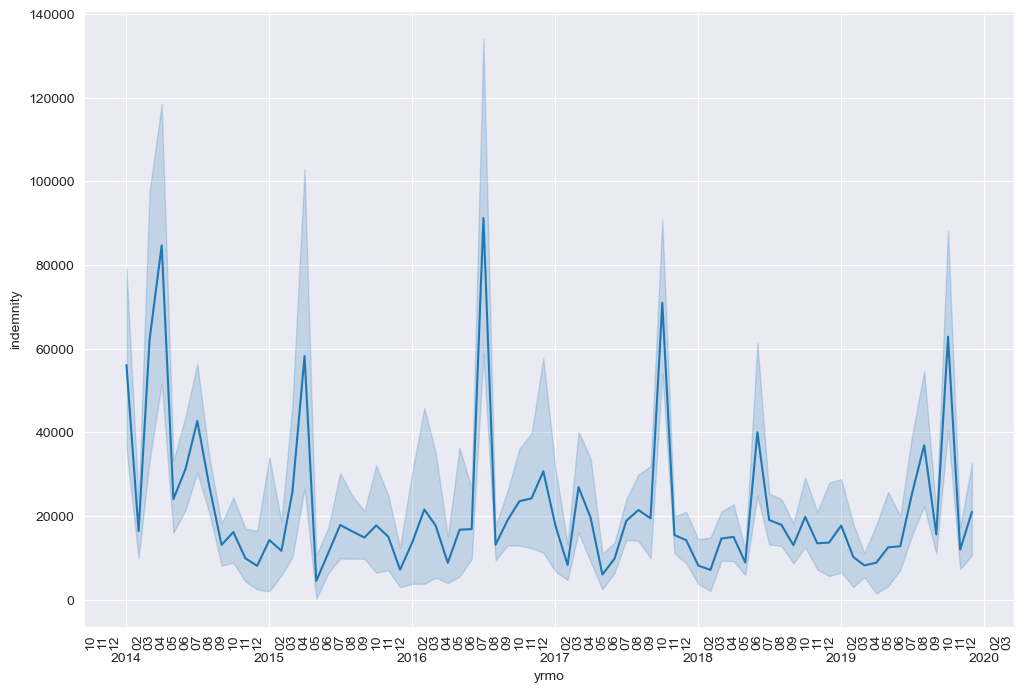

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create your figure with custom size (width, height)
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the height

sns.lineplot(x=crop_ind_by_yrmo_fps_crop['yrmo'], y=crop_ind_by_yrmo_fps_crop['indemnity'], ax=ax)

# Set major ticks (Year)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set minor ticks (Month)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
plt.tick_params(axis='x', which='minor')

# Increase the rotation for minor ticks for better visibility
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)  # Increase the rotation

# Lower major ticks
plt.tick_params(axis='x', which='major', pad=15)

plt.show()